## 4.1 实现 LLM 的架构

LLM（如GPT，即生成式预训练 Transformer，Generative Pretrained Transformer）是一种大型深度神经网络架构，设计用于逐词（或逐 token）生成新文本。然而，尽管模型规模庞大，其结构却并没有想象中那么复杂，因为模型的许多组件是重复的（后文将对此展开说明）。图 4.2 展示了一个类 GPT 的 LLM 的整体视图，并突出了其主要组成部分。

![Alt text](imgs/PixPin_2025-07-11_15-27-06.png)

我们通过以下 Python 字典来定义小型 GPT-2 模型的配置

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- ```vocab_size``` 指的是BPE分词器使用的50257个词汇的词表大小
- ```context_length``` 指的是模型所能处理的最大输入token数
- ```emb_dim``` 指的是嵌入维度，每个token转换为768维的向量
- ```n_layers```指定模型中 Transformer 模块的层数，后续章节将对此详解。
- ```drop_rate```表示 dropout 机制的强度（例如，0.1 表示丢弃 10% 的隐藏单元），用于防止过拟合，具体内容请回顾第 3 章。
- ```qkv_bias``` 参数决定是否在多头注意力的查询、键和值的线性层中加入偏置向量。我们最初会禁用该选项，以遵循现代大语言模型的标准，之后在第 6 章加载 OpenAI 预训练的 GPT-2 权重时再重新考虑该设置。

![Alt text](imgs/PixPin_2025-07-11_15-35-42.png)

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])      #A
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])                       #B
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len, = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):                                       #C
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):                                                     #D
        return x

class DummyLayerNorm(nn.Module):                                              #E
    def __init__(self, normalized_shape, eps=1e-5):                           #F
        super().__init__()

    def forward(self, x):
        return x


#A 为 TransformerBlock 设置占位符
#B 为 LayerNorm 设置占位符
#C 一个简单的占位类，后续将被真正的 TransformerBlock 替换
#D 该模块无实际操作，仅原样返回输入
#E 一个简单的占位类，后续将被真正的 DummyLayerNorm 替换
#F 此处的参数仅用于模拟LayerNorm接口


In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(f"这两段文本的token ID 如下：\n {batch}")

这两段文本的token ID 如下：
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
# 接下来，我们初始化一个拥有 1.24 亿参数的 DummyGPTModel 模型实例，并将分词后的数据批量输入到模型中：

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


输出的张量有两行，每行对应一段文本。每段文本包含 4 个 token，每个 token 是一个 50,257 维的向量，维度大小与分词器的词汇表相同。

嵌入层的维度为 50,257，因为**每个维度**对应词汇表中的**一个唯一 token**。在之后的处理中，我们会将这些 50,257 维向量转换回 token ID，然后再解码成单词。

## 4.2 使用层归一化(Layer norm)对激活值进行标准化

在训练深度神经网络时，梯度消失或梯度爆炸问题有时会带来挑战。这些问题会导致训练过程不稳定，使得网络难以有效调整权重，也就是说，模型难以找到一组能最小化损失函数的参数。换句话说，模型很难从数据中学习到足够准确的模式，以支持其做出准确的预测或决策。

> [!TIP]
>
> **个人思考：** 虽然对文本内容的理解并不需要深度掌握梯度的概念，但如果我们在学习过程中能习惯去发散，往往能帮助我们对所学知识理解的更深刻，下面我们就来聊一下梯度。
>
> 梯度本质上是一个**变化率**，描述了某个值（例如函数输出值）对另一个值（如输入变量）的变化趋势。简单来说，梯度告诉我们在当前位置上，朝哪个方向移动能让某个目标值增加或减少得更快。
>
> 举例：山坡上的爬山者
>
> 假设你站在一座山的某个位置，想要找到最快下山的路线。你会怎么做呢？首先你会注意到山坡的倾斜度（也就是梯度），倾斜越陡的地方，就意味着朝这个方向走可以让你更快地下降海拔。
>
> 在这个例子中：
>
> + **你的当前位置**代表模型当前的参数值。
> + **山坡的倾斜度**就是梯度，表示你在当前位置向下走的快慢和方向。
> + **往斜坡最陡的方向走**相当于使用梯度更新模型参数，使得海拔（也就是损失值）尽快下降。
>
> 而大模型在应用梯度的概念时，首先会设计一个损失函数，用来衡量模型的预测结果与目标结果的差距。在训练过程中，它通过梯度去帮助每个模型参数不断调整来快速减少损失函数的值，从而提高模型的预测精度。

归一化的```核心思想```是将神经网络层的激活（输出）调整为均值为 0，方差为 1（即单位方差）。这种调整可以加速权重的收敛速度，确保训练过程的一致性和稳定性。正如上一节提到的，在 GPT-2 和现代 Transformer 架构中，层归一化通常应用于多头注意力模块的前后以及最终输出层之前。

![Alt text](imgs/PixPin_2025-07-11_17-06-07.png)

In [5]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


在计算均值或方差等操作时使用 keepdim=True 参数，可以确保输出张量的维度与输入张量相同，即使该操作通过dim参数减少了张量的维度。例如，如果不使用 keepdim=True，返回的均值张量将是一个二维向量 [0.1324, 0.2170]，而使用 keepdim=True 后，返回的张量则会是一个 2×1 的矩阵 [[0.1324], [0.2170]]

![Alt text](imgs/PixPin_2025-07-12_16-46-29.png)

如图 4.6 所示，对于二维张量（如矩阵），在进行均值或方差计算等操作时，使用 dim=-1 等同于使用 dim=1，因为 -1 指的是张量的最后一个维度，即二维张量中的列。在后续对 GPT 模型加入层归一化时，模型会生成形状为 [batch_size, num_tokens, embedding_size] 的三维张量，我们依然可以使用 dim=-1 对最后一个维度进行归一化，而无需将 dim=1 改为 dim=2。

In [7]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim = -1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5     #epsilon, 防止出现除零错误
        self.scale = nn.Parameter(torch.ones(emb_dim))      #nn.Parameter, Tensor的subclass，
                                                            #1.自动设置 requires_grad=True；2.被 nn.Module 识别为“可学习参数”
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim = True, unbiased = True)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [9]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-1.4901e-08],
        [ 2.3842e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.8000],
        [0.8000]], grad_fn=<VarBackward0>)


## 4.3 实现带有 GELU 激活函数的前馈神经网络

GELU 和 SwiGLU 是更复杂、平滑的激活函数，分别结合了高斯分布和 sigmoid 门控线性单元。与较简单的 ReLU 不同，这些激活函数能为深度学习模型提供更好的性能。

GELU 激活函数可以通过多种方式实现，其确切版本定义为 GELU(x) = x ⋅ Φ(x)，其中 Φ(x) 是标准正态分布的累积分布函数。然而在实践中，通常会采用计算开销更低的近似实现（最初的 GPT-2 模型也是用这种近似实现进行训练的）：

$$ \text{GELU}(x) \approx 0.5 \cdot x \cdot\left(1+\tanh \left[\sqrt{(2 / \pi)} \cdot\left(x+0.044715 \cdot x^{3}\right]\right)\right. $$

In [10]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

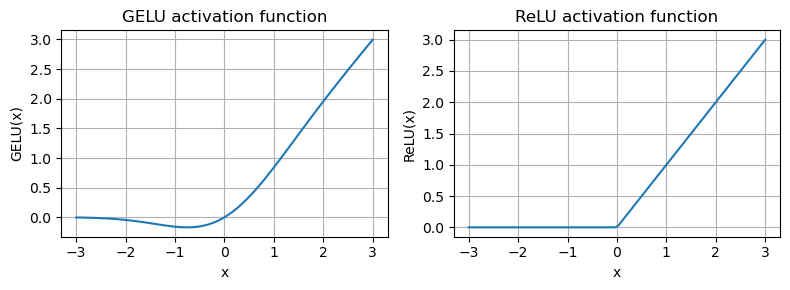

In [11]:
import matplotlib.pyplot as plt
#更直观的观察 GELU 函数的形状，并与 ReLU 函数进行对比，我们将这两个函数并排绘制：
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)                                          #A
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

#A 在 -3 到 3 的范围内生成 100 个样本数据点

```GELU``` 的**平滑性**使其在训练过程中具有更好的优化特性，能够对模型参数进行更细微的调整。相比之下，ReLU 在零点处有一个拐角，这在网络深度较大或结构复杂时可能会增加优化难度。此外，ReLU 对所有负输入的输出为零，而 GELU 对```负值```允许一个小的非零输出。这意味着在训练过程中，```接收负输入```的神经元也能对学习过程产生一定的贡献，尽管贡献程度不及正输入。

In [12]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
    def forward(self, x):
        return self.layers(x)

如代码所示，FeedForward 模块是一个小型神经网络，由两个线性层和一个 GELU 激活函数组成。在 1.24 亿参数的 GPT 模型中，该模块可以接收批量输入，每个输入 token 是一个 768 维的向量表示。这一嵌入维度大小通过 GPT_CONFIG_124M 配置字典中的 GPT_CONFIG_124M["emb_dim"] 参数指定。

![Alt text](imgs/PixPin_2025-07-12_17-39-02.png)

In [13]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)          #A
out = ffn(x)
print(out.shape)

#A 创建一个 batch 大小为 2 的示例输入

torch.Size([2, 3, 768])


> [!TIP]
> 为什么要“扩展 (Upscale)”或“收缩 (Downscale)”嵌入维度？
> 
> ```Upscale``` 的好处
> | 角度           | 具体收益                                                           | 说明                                  |
>| ------------ | -------------------------------------------------------------- | ----------------------------------- |
>| **表达能力提升**   | 更容易捕获复杂语义、细粒度上下文或高阶共现信息                                        | 维度越高，可容纳的“正交方向”越多；模型能学到更细的概念分解或特征交互 |
>| **线性可分性增强**  | 某些原本线性不可分的类别在高维空间往往可分                                          | “核技巧”直观：往高维投射==在原空间引入非线性            |
>| **梯度信号更丰富**  | 在 Transformer、Deep & Cross Network 等架构里，宽阔的嵌入能缓解信息瓶颈，减小梯度消失/饱和 | 与“增宽隐藏层”作用类似                        |
>| **多任务共享更灵活** | 同一个嵌入向量可同时服务多任务或多语言，维度大时任务间冲突更易被分割到不同子空间                       | 典型如 mBERT、M3E 等多语或多模态模型             |
> 
> ```Downscale``` 的好处
> | 角度           | 具体收益                         | 说明                            |
>| ------------ | ---------------------------- | ----------------------------- |
>| **内存与吞吐**    | 显存、带宽、IO 成本线性降低；推理时 QPS 提升显著 | 在大型召回/推荐系统中常用 16-32 维超小嵌入     |
>| **正则化与泛化**   | 低维空间对噪声的拟合能力下降，相当于隐式正则       | “降维=减少可学习自由度”，可抑制过拟合、提升小样本鲁棒性 |
>| **训练更快、更稳定** | 参数量少，梯度估计方差更低，收敛速度加快         | 对低资源任务、快速迭代原型尤其友好             |
>| **便于部署/蒸馏**  | 模型文件更小，延迟与能耗下降，可在移动端/边缘设备运行  | 结合量化、剪枝可进一步压缩                 |

![Alt text](imgs/PixPin_2025-07-12_17-47-55.png)

## 4.4 添加快捷连接

![Alt text](imgs/PixPin_2025-07-12_17-48-45.png)

In [14]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

以上代码实现了一个 5 层的深度神经网络，每层包括一个线性层和 GELU 激活函数。在前向传播中，我们将输入逐层传递，同时如果 self.use_shortcut 属性设置为 True，则会添加图 4.12 所示的快捷连接。

In [21]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

接下来，我们实现一个用于在模型反向传播过程中计算梯度的函数：

In [22]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()     

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

上述代码中，我们定义了一个损失函数，用来计算模型输出与用户指定目标（此处为简单起见，目标值设为 0）之间的差距。接着，当调用 loss.backward() 时，PyTorch 会为模型的每一层计算损失的梯度。我们可以通过 model.named_parameters() 遍历权重参数。假设某层的权重参数是一个 3×3 的矩阵，那么这一层会有 3×3 的梯度值。然后我们打印出这 3×3 梯度值的绝对均值，以便得到每层的单一梯度值，从而更容易比较各层之间的梯度大小。

In [23]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


从 print_gradients 函数的输出可以看出，梯度在从最后一层（layers.4）到第一层（layers.0）时逐渐减小，这种现象称为梯度消失问题。

In [24]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.2216978669166565
layers.1.0.weight has gradient mean of 0.20694100856781006
layers.2.0.weight has gradient mean of 0.3289698660373688
layers.3.0.weight has gradient mean of 0.2665731906890869
layers.4.0.weight has gradient mean of 1.3258538246154785


总之，快捷连接在解决深度神经网络中的梯度消失问题方面具有重要作用。作为 LLM 的核心构建单元，快捷连接可以确保各层之间的梯度稳定流动，从而帮助 GPT 模型更有效的训练（下一章实现训练过程）



## 4.5 在 Transformer 模块中连接注意力层与线性层

![Alt text](imgs/PixPin_2025-07-14_13-51-22.png)

In [25]:
%run ./3_Coding_Attention_Mechanisms.ipynb




===== Self-Attention 结果 (含位置编码) =====

       x1        x2       x3       T1       T2       T3       T4       T5       T6       o1       o2       o3
 1.271471  0.690302 0.890005 0.315381 0.239435 0.105702 0.044346 0.066093 0.229044 1.273928 1.060221 0.435727
 1.459297  0.453853 0.660009 0.296198 0.233471 0.115046 0.054239 0.076627 0.224420 1.236005 1.028942 0.420495
 0.711120 -0.139992 0.640014 0.231497 0.205499 0.144342 0.099181 0.117838 0.201644 1.086208 0.905413 0.360154
-0.536803 -0.073644 0.330019 0.162206 0.163468 0.167715 0.172386 0.170190 0.164035 0.885203 0.739702 0.278801
-0.188924  0.533662 0.100023 0.193902 0.184244 0.158497 0.135087 0.145366 0.182904 0.982739 0.820102 0.318358
-0.229415  1.760170 0.550028 0.288950 0.230573 0.118408 0.058350 0.080746 0.222973 1.221021 1.016597 0.414371
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
tensor([0.4419, 0.6515, 0.5683])
tensor([

In [28]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg=cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

层归一化（LayerNorm）在这两个组件（即自注意力和前馈网络）之前应用，而 dropout 则在它们之后应用，用于正则化模型并防止过拟合。这种方式也称为前置层归一化（Pre-LayerNorm）。而在早期的架构中（如原始的 Transformer 模型），一般将层归一化应用在自注意力和前馈网络之后，这被称为后置层归一化（Post-LayerNorm），这种方式通常会导致较差的训练效果。

In [29]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)                    #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

#A 建一个形状为 [batch_size, num_tokens, emb_dim] 的输入张量

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


Transformer 模块结构中保持数据形状不变并非偶然，而是其设计的一个关键特性。这种设计使 Transformer 擅长处理各种序列到序列任务，因为每个输出向量直接对应一个输入向量，保持一一对应关系。然而，虽然维度一致，但输出向量是包含整个输入序列信息的“上下文向量”。也就是说，尽管序列的物理维度（长度和特征维度）在经过 Transformer 模块时保持不变，但每个输出向量的内容会被重新编码，融合整个输入序列的上下文信息。

## 4.6 实现 GPT 模型

![Alt text](imgs/PixPin_2025-07-14_15-42-01.png)

In [33]:
# Listing 4.7 The GPT model architecture implementation
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))      #A
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

 #A 设备设置将根据输入数据所在的位置选择在 CPU 或 GPU 上训练模型

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0079, -0.1957,  ..., -0.0222, -0.1062,  0.1717],
         [ 0.3867, -0.8400, -0.6558,  ..., -0.5162,  0.2362, -0.3349],
         [ 0.6985, -0.1826, -0.1634,  ...,  0.1472, -0.6503, -0.0054],
         [-0.4288,  0.1670, -0.1262,  ...,  1.1571,  0.5297, -0.5542]],

        [[ 0.1095, -0.2890, -0.1463,  ..., -0.0557,  0.2907, -0.2818],
         [ 0.0884, -0.3545, -0.3524,  ...,  1.2921,  0.0050,  0.1902],
         [ 0.6092,  0.4702, -0.4093,  ...,  0.7682,  0.3781, -0.1968],
         [-0.0608, -0.0739,  0.4747,  ...,  1.2458, -0.3834,  0.0612]]],
       grad_fn=<UnsafeViewBackward0>)


可以看到，输出张量的形状是 [2, 4, 50257]，这是因为我们输入了 2 个文本，每个文本包含 4 个 token。最后一个维度 50257 对应于分词器的词汇表大小。在下一节中，我们将看到如何将这些 50257 维的输出向量转换回 token。

使用 numel() 方法（即 number of elements 的缩写），可以统计模型中参数张量的总参数量：

In [36]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


我们之前提到 GPT 模型的参数量为 1.24 亿，但代码输出的实际参数量却是 1.63 亿，这是为什么呢？

原因在于 GPT-2 架构中使用了一种称为‘权重共享’的概念，这意味着 GPT-2 架构将 token 嵌入层的权重复用于输出层。

token 嵌入层和输出层的参数量很大，因为分词器词汇表中包含 50,257 个 token。根据权重共享原则，我们可以从 GPT-2 模型的总参数量中去除输出层的参数量。

In [37]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print("\n-------------------")
print(f"\nNumber of trainable parameters considering weight tying: {total_params_gpt2:,}")

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])

-------------------

Number of trainable parameters considering weight tying: 124,412,160


In [41]:
def count_mha_ffn(model):
    mha, ffn = 0, 0
    for block in model.trf_blocks:          # 逐层
        mha += sum(p.numel() for p in block.att.parameters() if p.requires_grad)
        ffn += sum(p.numel() for p in block.ff.parameters()  if p.requires_grad)
    return mha, ffn

mha, ffn = count_mha_ffn(model)
print(f"MHA number of parameters: {mha:,}")
print(f"FFN number of parameters:  {ffn:,}")


MHA number of parameters: 28,320,768
FFN number of parameters:  56,669,184


In [42]:
total_size_bytes = total_params * 4                 #A
total_size_mb = total_size_bytes / (1024 * 1024)    #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


GPT-2 medium

In [47]:
torch.manual_seed(123)
GPT_CONFIG_medium = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1600,         # Embedding dimension
    "n_heads": 25,          # Number of attention heads
    "n_layers": 48,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
model_medium = GPTModel(GPT_CONFIG_medium)
out_medium = model_medium(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out_medium.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.3184,  0.2476, -0.0316,  ..., -0.0517, -0.0864, -0.3170],
         [ 0.1490, -0.2821, -0.4085,  ..., -0.1722,  0.5008,  0.3073],
         [ 0.5052, -0.2710,  0.4978,  ..., -0.1405, -0.6055, -0.2000],
         [-1.3377, -0.0232, -0.0723,  ...,  1.3942,  0.2077, -0.7040]],

        [[-0.0803, -0.3320, -0.0305,  ...,  0.0070, -0.1439, -1.1663],
         [ 0.0586,  0.0853,  0.1376,  ...,  0.4377,  0.0424,  0.7175],
         [ 0.9623,  0.5480,  0.1374,  ...,  0.6531, -0.2354,  0.1913],
         [-0.0499,  0.3240,  0.4199,  ...,  1.4464,  0.0243, -0.0925]]],
       grad_fn=<UnsafeViewBackward0>)


In [48]:
total_params_medium = sum(p.numel() for p in model_medium.parameters())
print(f"Total number of parameters: {total_params_medium:,}")
total_params_gpt2_medium = total_params_medium - sum(p.numel() for p in model_medium.out_head.parameters())
print("\n-------------------")
print(f"\nNumber of trainable parameters considering weight tying: {total_params_gpt2_medium:,}")

Total number of parameters: 1,637,792,000

-------------------

Number of trainable parameters considering weight tying: 1,557,380,800


## 4.7 生成文本

![Alt text](imgs/PixPin_2025-07-14_16-20-59.png)

如图 4.16 所示，GPT 模型在给定输入上下文（例如 ‘Hello, I am’）后，逐步生成文本。每次迭代中，输入上下文会不断扩展，使模型能够生成连贯且符合上下文的内容。在第 6 次迭代时，模型已构建出完整句子 ‘Hello, I am a model ready to help.’。

在上一节，我们看到目前的 GPTModel 输出的张量形状为 [batch_size, num_token, vocab_size]。那么问题来了，GPT 模型是如何将这些输出张量转化为图 4.16 所示的生成文本的呢？

GPT 模型从输出张量到生成文本的过程涉及几个步骤（如图 4.17 所示）。这些步骤包括解码输出张量、根据概率分布选择 token，并将其转化为可读文本。

![Alt text](imgs/PixPin_2025-07-14_16-22-15.png)

在每一步，模型会输出一个矩阵，其中的向量表示潜在的下一个 token。取出对应于下一个 token 的向量，并通过 softmax 函数将其转换为概率分布。在包含概率分数的向量中，找到最高值的索引，并将其转换为 token ID。将该 token ID 解码回文本，得到序列中的下一个 token。最后，将该 token 添加到先前的输入中，形成下一次迭代的新输入序列。这种逐步生成的过程使模型能够根据初始输入上下文，按顺序生成文本，从而构建出连贯的短语和句子。

In [51]:
# Listing 4.8 A function for the GPT model to generate text
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]                           #B
        with torch.no_grad():
           logits = model(idx_cond)

        logits = logits[:, -1, :]                                   #C
        probas = torch.softmax(logits, dim=-1)                      #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)       #E
        idx = torch.cat((idx, idx_next), dim=1)                     #F

    return idx


#A idx 是当前上下文中索引的数组，形状为 (batch, n_tokens)
#B 若上下文长度超出支持范围，则进行裁剪。例如，若模型仅支持 5 个 token，而上下文长度为 10，仅使用最后 5 个 token 作为上下文
#C 仅关注最后一个时间步，将形状从 (batch, n_token, vocab_size) 转换为 (batch, vocab_size)
#D probas 的形状为 (batch, vocab_size)
#E idx_next 的形状为 (batch, 1)
#F 将采样的索引追加到当前序列中，此时 idx 的形状为 (batch, n_tokens+1)

在上述代码中，generate_text_simple 函数使用 Softmax 函数将 logits 转换为概率分布，然后通过 torch.argmax 找出概率最高的位置。Softmax 函数是单调的，这意味着它会保持输入的相对顺序，因此，Softmax 这一步实际上是冗余的，因为 Softmax 输出中最高值的位置与原始 logits 中最高值的位置相同。换句话说，我们可以直接对 logits 应用 torch.argmax 得到相同的结果。不过，我们保留了这个转换过程，以展示从 logits 到概率的完整过程，有助于理解模型如何生成最可能的下一个词，这种方式称为贪婪解码。

![Alt text](imgs/PixPin_2025-07-14_16-36-45.png)

In [52]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(f"encoded: {encoded}")
encoded_tensor = torch.tensor(encoded).unsqueeze(0)            #A
print("encoded_tensor.shape:", encoded_tensor.shape)

model.eval()


encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_porj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_feature

In [58]:
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Hello, I am Featureiman Byeswickattribute argue
